In [3]:
# make it wide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
# show graphs in the notebook
%matplotlib inline

In [5]:
# lots of imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import numpy as np
import json
from pandas.io.json import json_normalize


In [6]:
# fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
# channelGrouping - The channel via which the user came to the Store.
# date - The date on which the user visited the Store.
# device - The specifications for the device used to access the Store.
# geoNetwork - This section contains information about the geography of the user.
# sessionId - A unique identifier for this visit to the store.
# socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
# totals - This section contains aggregate values across the session.
# trafficSource - This section contains information about the Traffic Source from which the session originated.
# visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
# visitNumber - The session number for this user. If this is the first session, then this is set to 1.
# visitStartTime - The timestamp (expressed as POSIX time).

In [7]:
json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']

In [8]:
def json_read(path):
    df = pd.read_csv(path, 
                     converters={column: json.loads for column in json_columns},
                     dtype={'fullVisitorId': 'str'})
    
    for column in json_columns:
        column_as_df = json_normalize(df[column]) 
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns] 
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        
    return df

In [9]:
df = json_read('train.csv')

In [10]:
df.shape

(903653, 55)

In [11]:
# for quick testing of feature extraction
df_small = df.copy().sample(10000)

In [12]:
def process_numbers(df):
    df['totals.pageviews'].fillna(1, inplace=True)
    df['totals.newVisits'].fillna(0, inplace=True)
    df['totals.bounces'].fillna(0, inplace=True)
    # try/catch since this doesn't exist in test data
    try:
        df["totals.transactionRevenue"] = df["totals.transactionRevenue"].fillna(0.0).astype(float)
    except:
        pass
    df['totals.pageviews'] = df['totals.pageviews'].astype(int) 
    df['totals.newVisits'] = df['totals.newVisits'].astype(int) 
    df['totals.bounces'] = df['totals.bounces'].astype(int)  
    df["totals.hits"] = df["totals.hits"].astype(float) 
    df['trafficSource.isTrueDirect'].fillna(False, inplace=True) 
    df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True) 

    return df

In [13]:
#df = process_numbers(df)
df = process_numbers(df)

In [14]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [15]:
# make lots of date features, including month, year, day of week, start times, time between start and first visit, and holidays
def process_date(df):
    df['date'] = df['date'].astype(str)
    df["date"] = df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    df["date"] = pd.to_datetime(df["date"])
    df["weekday"] = df['date'].dt.weekday
    df["year"] = df['date'].dt.year
    df["day"] = df['date'].dt.day
    df["month"] = df['date'].dt.month
    
    df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], unit='s')

    df["startweekday"] = df['visitStartTime'].dt.weekday
    df["startyear"] = df['visitStartTime'].dt.year
    df["startday"] = df['visitStartTime'].dt.day
    df["startmonth"] = df['visitStartTime'].dt.month
    
    df['starthour'] = df['visitStartTime'].dt.hour
    
    df['days_since_first'] = ((df['visitStartTime'] - df['date']).dt.seconds / 60 / 24 )
    
    minn, maxx = min(df['date']), max(df['date'])
    cal = calendar()
    holidays = cal.holidays(start=minn, end=maxx)

    df['is_holiday'] = df['date'].isin(holidays)

    return df 

In [16]:
df = process_date(df)

In [17]:
df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,year,day,month,startweekday,startyear,startday,startmonth,starthour,days_since_first,is_holiday
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,2016-09-02 15:33:05,Chrome,not available in demo dataset,...,2016,2,9,4,2016,2,9,15,38.878472,False
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,2016-09-03 05:22:27,Firefox,not available in demo dataset,...,2016,2,9,5,2016,3,9,5,13.435417,False
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,2016-09-03 01:16:26,Chrome,not available in demo dataset,...,2016,2,9,5,2016,3,9,1,3.184722,False
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,2016-09-03 05:40:13,UC Browser,not available in demo dataset,...,2016,2,9,5,2016,3,9,5,14.175694,False
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,2016-09-02 13:23:20,Chrome,not available in demo dataset,...,2016,2,9,4,2016,2,9,13,33.472222,False


In [18]:
df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue

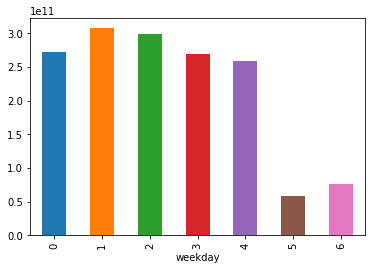

In [19]:
df.groupby('weekday')['totals.transactionRevenue'].agg(sum).plot(kind='bar')

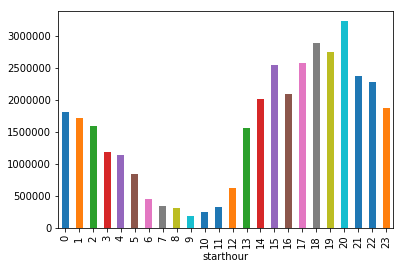

In [20]:
df.groupby('starthour')['totals.transactionRevenue'].agg(np.mean).plot(kind='bar')

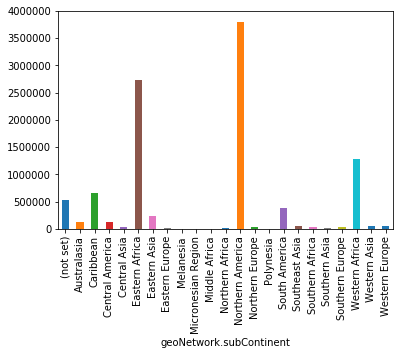

In [21]:
df.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(np.mean).plot(kind='bar')

In [22]:
visit_datetime_df = df[["date","visitNumber", 'totals.transactionRevenue']]
visit_datetime_df["visitNumber"] = visit_datetime_df.visitNumber.astype(np.int64)

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


{'bodies': [<matplotlib.collections.PolyCollection at 0x20698f193c8>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x20698f19588>,
 'cmins': <matplotlib.collections.LineCollection at 0x20698f192e8>,
 'cbars': <matplotlib.collections.LineCollection at 0x20698f15710>,
 'cmedians': <matplotlib.collections.LineCollection at 0x20698f15240>}

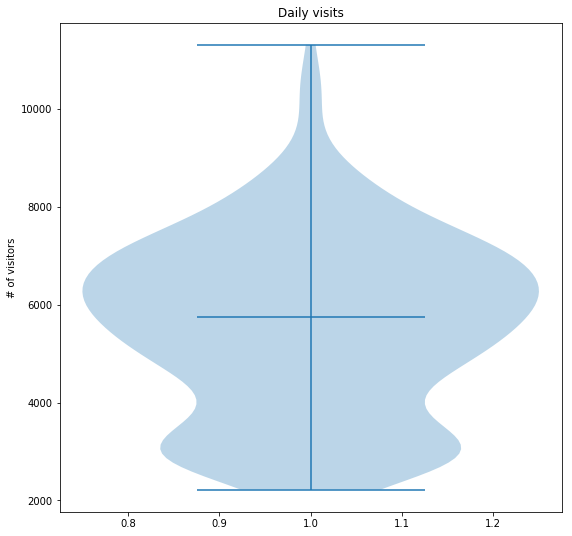

In [23]:
daily_visit_df = visit_datetime_df.groupby(by=["date"], axis = 0).sum()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
axes.set_title("Daily visits")
axes.set_ylabel("# of visitors")
axes.violinplot(list(daily_visit_df["visitNumber"].values),showmeans=False,showmedians=True)

In [24]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [25]:
minn, maxx = min(df['date']), max(df['date'])
cal = calendar()
holidays = cal.holidays(start=minn, end=maxx)

df['is_holiday'] = df['date'].isin(holidays)

In [26]:
daily_visit_df['date'] = daily_visit_df.index

In [27]:
daily_visit_df['is_holiday'] = daily_visit_df['date'].isin(holidays)

In [28]:
# we sell much much less on holidays

In [29]:
daily_visit_df.groupby('is_holiday')['totals.transactionRevenue'].describe()

,count,mean,std,min,25%,50%,75%,max
is_holiday,,,,,,,,
False,356.0,4.269220e+09,3.425724e+09,0.0,1.831108e+09,3.896970e+09,5.594795e+09,2.715061e+10
True,10.0,2.022905e+09,1.278273e+09,379980000.0,1.088945e+09,1.654525e+09,2.669048e+09,4.251430e+09


In [30]:
# see average sales per day

In [31]:
daily_visit_df['sales_ratio'] = daily_visit_df["visitNumber"].values / daily_visit_df["totals.transactionRevenue"]

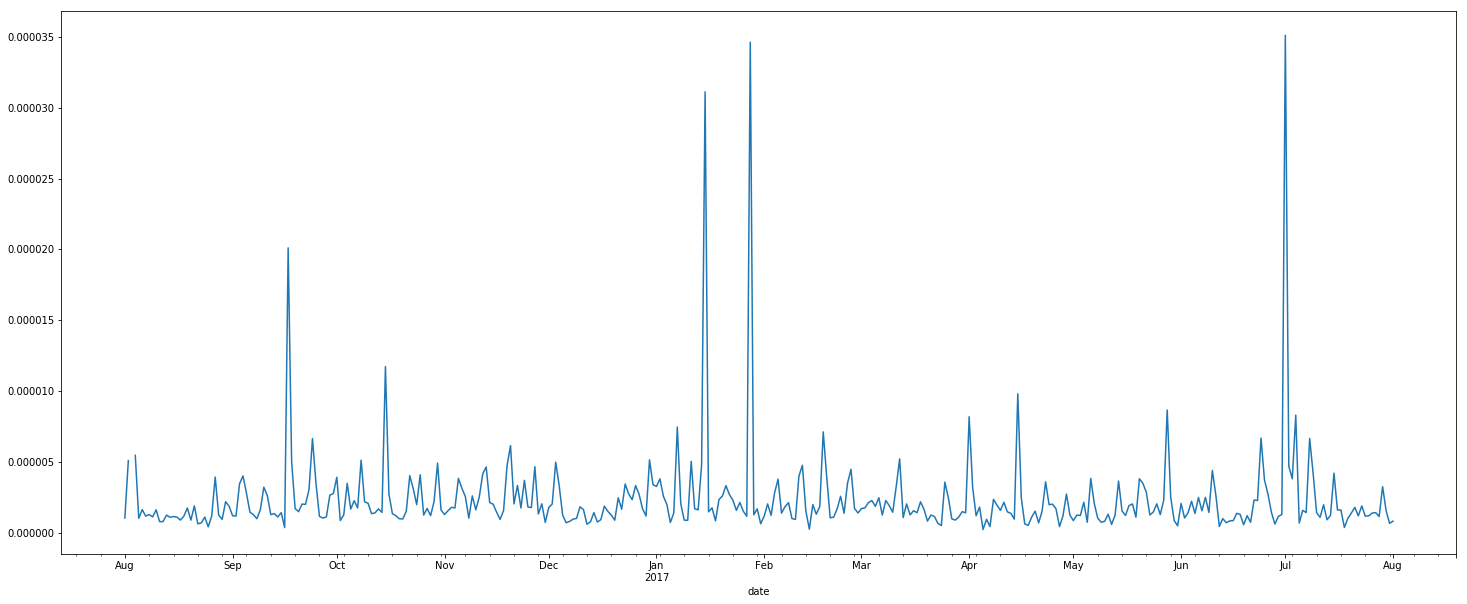

In [32]:
daily_visit_df.sales_ratio.plot(figsize=(25,10))

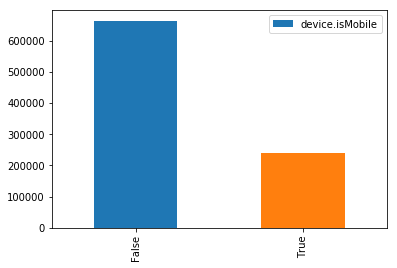

In [33]:
df["device.isMobile"].value_counts().plot(kind="bar",legend="isMobile")

In [34]:
# plot by largest countries per continent -- clearly some countries dominate

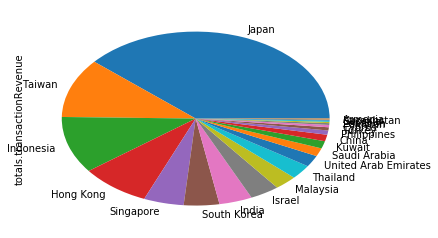

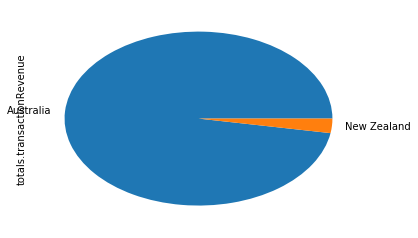

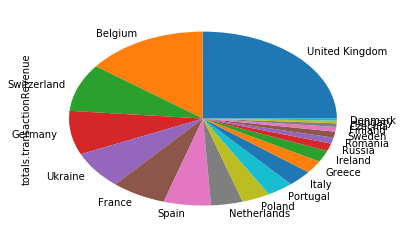

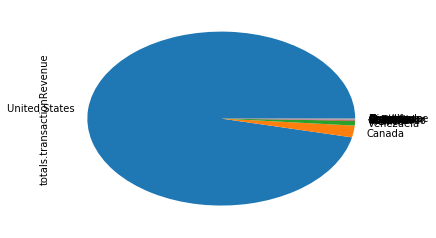

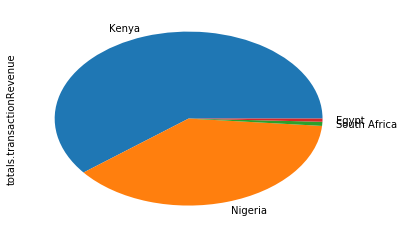

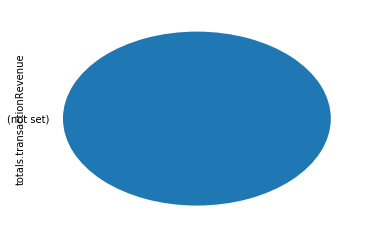

In [35]:
for continent in df['geoNetwork.continent'].unique():
    df[df['geoNetwork.continent'] == continent].groupby('geoNetwork.country')['totals.transactionRevenue'].agg(sum).sort_values(ascending=False).plot(kind='pie')
    plt.show()

In [36]:
# autocorrelation
corr = df.corr()
corr.style.background_gradient()

,visitId,visitNumber,device.isMobile,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.isTrueDirect,weekday,year,day,month,startweekday,startyear,startday,startmonth,starthour,days_since_first,is_holiday
visitId,1,0.00206887,0.144332,-0.000130569,-0.0277009,-0.0410354,-0.0222608,0.00272373,-0.029576,0.0731886,0.00175683,0.86307,0.0655399,-0.502336,-0.000381549,0.862957,0.0611286,-0.501603,0.00958899,0.00955432,-0.0352738
visitNumber,0.00206887,1,-0.0376666,-0.0237544,0.0413169,-0.255077,0.0433384,0.0513664,-0.00133188,0.181692,-0.0201309,0.00787589,-0.00278949,-0.0112749,-0.0193282,0.00787164,-0.00257096,-0.0113342,0.0249005,0.0248206,-0.00483038
device.isMobile,0.144332,-0.0376666,1,0.021394,-0.0303667,0.021656,-0.0301845,-0.0165545,-0.0772582,0.07869,0.0789367,0.144849,0.00172545,-0.106979,0.0821225,0.145116,0.00261732,-0.107246,-0.025011,-0.0250811,0.00202758
totals.bounces,-0.000130569,-0.0237544,0.021394,1,-0.371136,0.0788413,-0.404546,-0.0322056,0.0526421,-0.0445477,0.0210264,0.00265162,0.00249229,-0.00466728,0.0188292,0.0026402,0.00162853,-0.00469152,-0.0308941,-0.0308851,0.00235685
totals.hits,-0.0277009,0.0413169,-0.0303667,-0.371136,1,-0.115202,0.983204,0.154333,-0.0404723,0.0839598,-0.0116821,-0.0175019,-0.00503063,0.00312441,-0.0108187,-0.0175137,-0.00404197,0.00315577,0.0173179,0.0171898,-0.00847527
totals.newVisits,-0.0410354,-0.255077,0.021656,0.0788413,-0.115202,1,-0.117174,-0.0411637,0.039879,-0.616041,0.0401103,-0.0436779,0.00340401,0.0344164,0.0386428,-0.0436876,0.00306332,0.0344754,-0.0437888,-0.0437156,0.00911544
totals.pageviews,-0.0222608,0.0433384,-0.0301845,-0.404546,0.983204,-0.117174,1,0.15559,-0.0446736,0.0843419,-0.0124533,-0.0112485,-0.00480732,-0.00231095,-0.011548,-0.0112411,-0.00383066,-0.00230118,0.018785,0.0186546,-0.00896727
totals.transactionRevenue,0.00272373,0.0513664,-0.0165545,-0.0322056,0.154333,-0.0411637,0.15559,1,-0.000833726,0.0308188,-0.00781222,0.0031945,0.000560627,-0.00284859,-0.00733085,0.0031883,0.000254477,-0.00283285,0.0110513,0.0109858,-0.00262206
trafficSource.adwordsClickInfo.isVideoAd,-0.029576,-0.00133188,-0.0772582,0.0526421,-0.0404723,0.039879,-0.0446736,-0.000833726,1,0.0434992,-0.0172401,-0.0178672,-0.00237477,0.00192808,-0.0164829,-0.0180085,-0.00242238,0.00202395,0.00739806,0.00746677,-0.0017068
trafficSource.isTrueDirect,0.0731886,0.181692,0.07869,-0.0445477,0.0839598,-0.616041,0.0843419,0.0308188,0.0434992,1,-0.043235,0.0833047,0.00709091,-0.0716432,-0.0409496,0.0832614,0.00851701,-0.0717092,0.0426275,0.0425367,-0.0123845


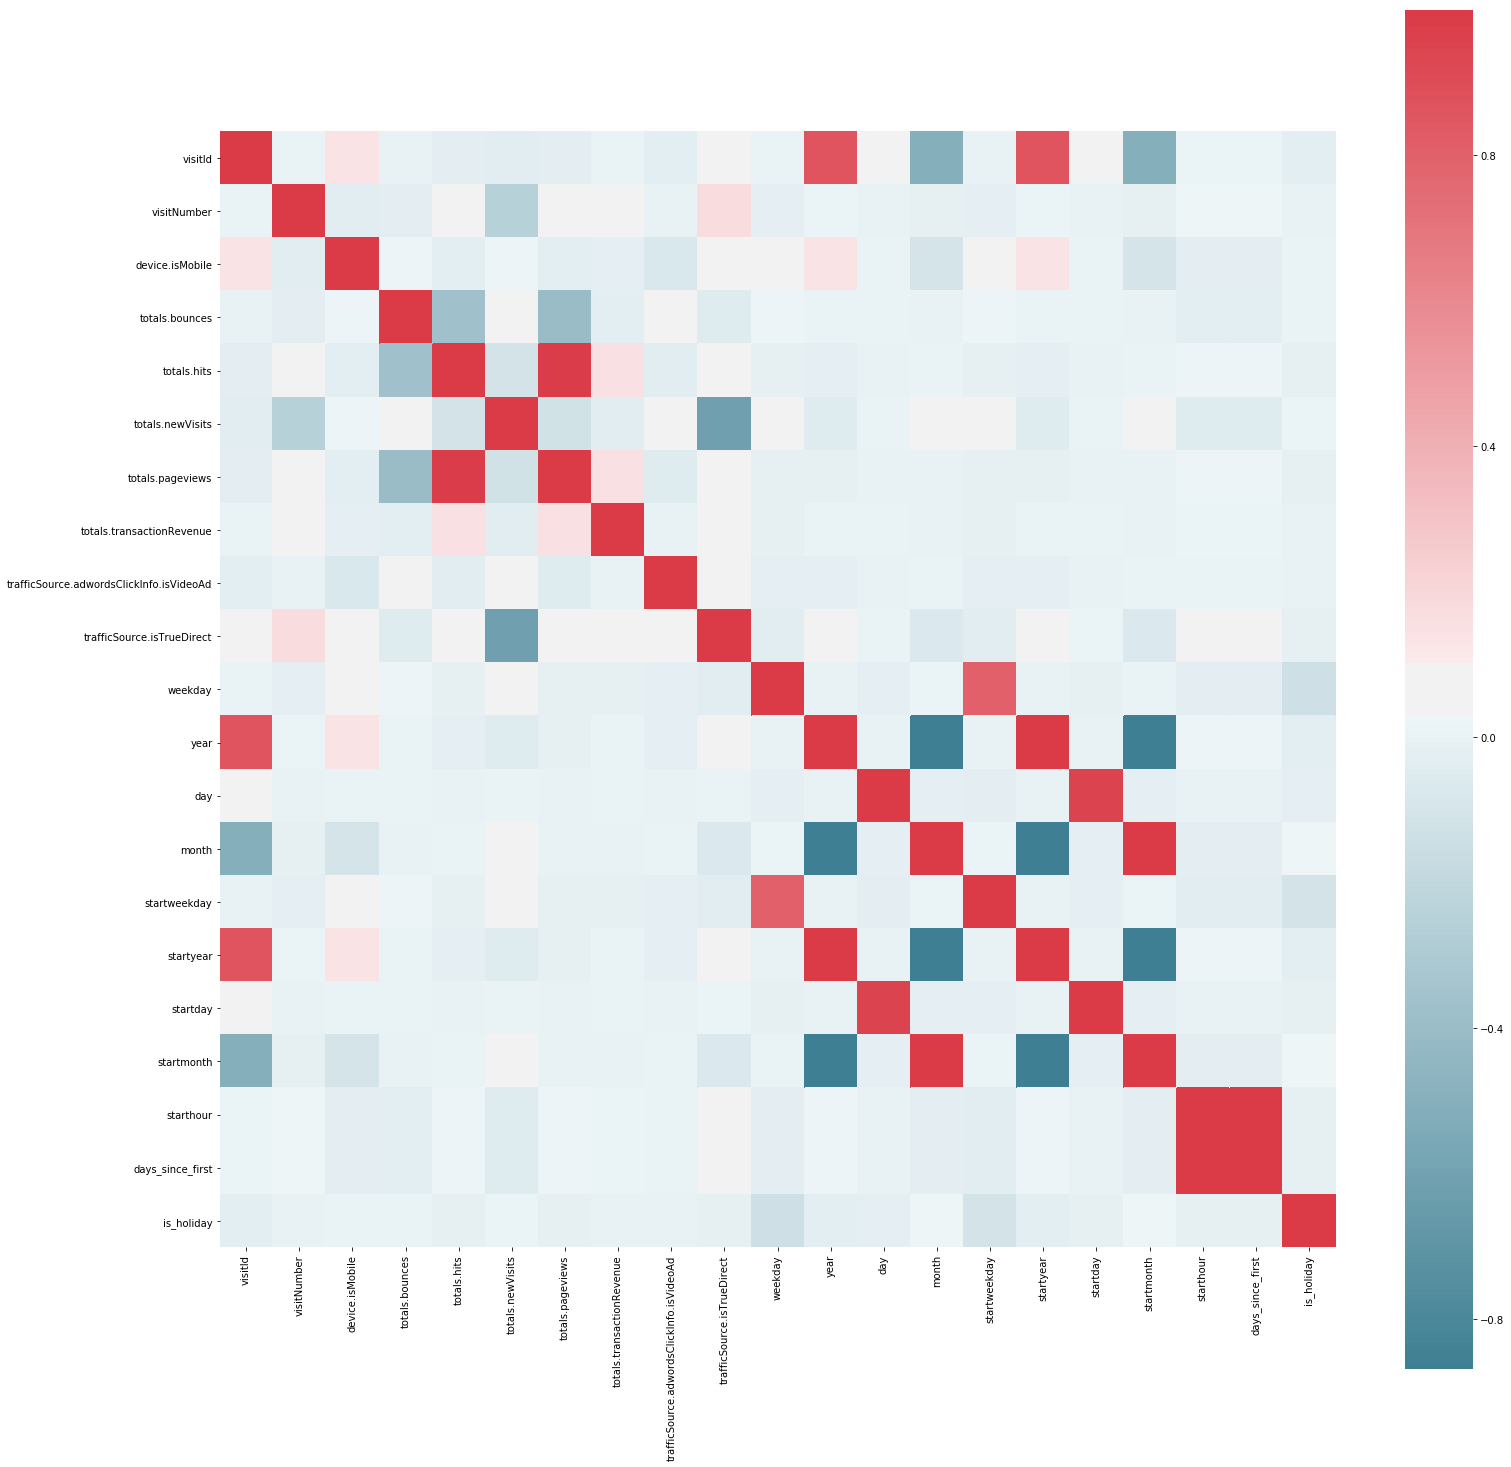

In [37]:
# autocorrelation again

f, ax = plt.subplots(figsize=(25, 25))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [38]:
# get rid of columns that never change

In [39]:
constants = [col for col in df.columns if df[col].nunique() == 1]

df.drop(constants, axis=1, inplace=True) 


In [40]:
features = df.copy()

In [41]:
features.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,year,day,month,startweekday,startyear,startday,startmonth,starthour,days_since_first,is_holiday
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,2016-09-02 15:33:05,Chrome,desktop,False,...,2016,2,9,4,2016,2,9,15,38.878472,False
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,2016-09-03 05:22:27,Firefox,desktop,False,...,2016,2,9,5,2016,3,9,5,13.435417,False
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,2016-09-03 01:16:26,Chrome,desktop,False,...,2016,2,9,5,2016,3,9,1,3.184722,False
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,2016-09-03 05:40:13,UC Browser,desktop,False,...,2016,2,9,5,2016,3,9,5,14.175694,False
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,2016-09-02 13:23:20,Chrome,mobile,True,...,2016,2,9,4,2016,2,9,13,33.472222,False


In [42]:
# some light NLP to group keywords
import string
def clean_keyword(keyword):
    nums = len([int(s) for s in keyword.split() if s.isdigit()])
    letters = len([[s for s in keyword.split() if not s.isdigit() and s != ' ']])
    if nums > 3 and letters > 3:
        return 'CODE'
    return ''.join([x for x in keyword.lower() if x not in string.punctuation])



In [43]:
# fill and clean keywords, the main text field

In [44]:
features['trafficSource.keyword'] = features['trafficSource.keyword'].fillna('Other').apply(clean_keyword)


In [45]:
# categoricals
cat_cols = ["channelGrouping", 
            "device.deviceCategory",
            "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign", "trafficSource.medium", 
            "trafficSource.referralPath", 
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect',
           'weekday', 'month', 'year', 'startweekday', 'startyear', 'startday', 'startmonth', 'starthour']
# categoricals to bucket the small ones, so data sparsity doesn't bite us
bagged_categorical_features = ['trafficSource.keyword', 'device.operatingSystem', "device.browser", "geoNetwork.city", "trafficSource.source"]
cat_cols = cat_cols + bagged_categorical_features

In [46]:
from sklearn import preprocessing

In [47]:
unique_counts = features.T.apply(lambda x: x.nunique(), axis=1)

In [48]:
unique_counts

channelGrouping                                      8
date                                               366
fullVisitorId                                   714167
sessionId                                       902755
visitId                                         886303
visitNumber                                        384
visitStartTime                                  887159
device.browser                                      54
device.deviceCategory                                3
device.isMobile                                      2
device.operatingSystem                              20
geoNetwork.city                                    649
geoNetwork.continent                                 6
geoNetwork.country                                 222
geoNetwork.metro                                    94
geoNetwork.networkDomain                         28064
geoNetwork.region                                  376
geoNetwork.subContinent                             23
totals.bou

In [49]:
# transform cat/bagged cat features, keeping the encoder

In [50]:
encoders = {}
for col in cat_cols:
    if unique_counts[col] <= 100 or True:
        print(col, unique_counts[col])
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(features[col].values.astype('str')))
        encoders[col] = lbl
        features[col] = lbl.transform(list(features[col].values.astype('str')))

for col in bagged_categorical_features:
    lbl = preprocessing.LabelEncoder()
    value_counts = features[col].value_counts()
    value_counts['Other'] = 100000
    value_counts['None'] = 100000
    # nans are nones
    features[col] = features[col].fillna('None')
    # make all ones with <1000 of them "other"
    try:
        cutoff = max(sorted(value_counts)[-25], 1000)
    except:
        cutoff = 1000
    
    features[col] = [x if value_counts.get(x, 0) > cutoff else 'Other' for x in features[col].values.astype('str')]
    
    lbl.fit(list(features[col].values.astype('str')))

    encoders[col] = lbl
    features[col] = lbl.transform(list(features[col].values.astype('str')))


channelGrouping 8
device.deviceCategory 3
geoNetwork.continent 6
geoNetwork.country 222
geoNetwork.metro 94
geoNetwork.networkDomain 28064
geoNetwork.region 376
geoNetwork.subContinent 23
trafficSource.adContent 44
trafficSource.adwordsClickInfo.adNetworkType 2
trafficSource.adwordsClickInfo.gclId 17774
trafficSource.adwordsClickInfo.page 8
trafficSource.adwordsClickInfo.slot 2
trafficSource.campaign 10
trafficSource.medium 7
trafficSource.referralPath 1475
trafficSource.adwordsClickInfo.isVideoAd 2
trafficSource.isTrueDirect 2
weekday 7
month 12
year 2
startweekday 7
startyear 2
startday 31
startmonth 12
starthour 24
trafficSource.keyword 3302
device.operatingSystem 20
device.browser 54
geoNetwork.city 649
trafficSource.source 380


In [51]:
len(features.iloc[0])

46

In [52]:
import datetime

In [53]:
# if we want to train on a set of features - gotten in another cell below
good_features = [
"trafficSource.source",
"trafficSource.isTrueDirect",
"month",
"trafficSource.keyword",
"geoNetwork.networkDomain",
"trafficSource.adwordsClickInfo.adNetworkType",
"device.browser",
"startmonth",
"channelGrouping",
"startday",
"device.deviceCategory",
"day",
"geoNetwork.metro",
"geoNetwork.city",
"device.isMobile",
"device.operatingSystem",
"trafficSource.campaign",
"geoNetwork.region",
"starthour",
"trafficSource.referralPath",
"geoNetwork.country",
"totals.newVisits",
"geoNetwork.continent",
"visitNumber",
"totals.hits",
"trafficSource.medium",
"geoNetwork.subContinent",
"totals.pageviews",
]

In [54]:
# if we want a train/test set or to just train on everything (former for testing, latter for submission)

In [55]:


# train = features[features['date']<=datetime.date(2017,6,30)][good_features + ['totals.transactionRevenue', 'fullVisitorId']]
# test = features[features['date']>datetime.date(2017,6,30)][good_features + ['totals.transactionRevenue', 'fullVisitorId']]

train = features
test = features[features['date']>datetime.date(2017,6,30)]


C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.


In [56]:
# train = train.drop(['date', 'visitStartTime'], axis=1)
# test = test.drop(['date', 'visitStartTime'], axis=1)
features = features.drop(['fullVisitorId', 'sessionId','visitId'], axis=1)

In [57]:
features = features.drop(['date'], axis=1)

In [58]:
features = features.drop(['visitStartTime'], axis=1)

In [59]:
features

,channelGrouping,visitNumber,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,...,year,day,month,startweekday,startyear,startday,startmonth,starthour,days_since_first,is_holiday
0,4,1,0,0,False,0,0,3,204,0,...,0,2,11,4,0,11,11,7,38.878472,False
1,4,1,0,0,False,0,0,5,12,93,...,0,2,11,5,0,22,11,19,13.435417,False
2,4,1,0,0,False,0,0,4,181,0,...,0,2,11,5,0,22,11,1,3.184722,False
3,4,1,0,0,False,0,0,3,94,93,...,0,2,11,5,0,22,11,19,14.175694,False
4,4,2,0,1,True,0,0,4,211,93,...,0,2,11,4,0,11,11,5,33.472222,False
5,4,1,0,0,False,0,0,4,100,93,...,0,2,11,4,0,11,11,23,22.773611,False
6,4,1,0,0,False,0,0,3,152,93,...,0,2,11,4,0,11,11,3,29.750694,False
7,4,1,0,0,False,0,0,5,12,0,...,0,2,11,4,0,11,11,2,26.529167,False
8,4,1,0,0,False,0,0,4,13,93,...,0,2,11,4,0,11,11,22,21.794444,False
9,4,1,0,0,False,0,0,4,142,93,...,0,2,11,4,0,11,11,2,26.300000,False


# Logistic Regression - creating binary model

In [60]:
features["totals.transactionRevenue"] == 0

0         True
1         True
2         True
3         True
4         True
5         True
6         True
7         True
8         True
9         True
10        True
11        True
12        True
13        True
14        True
15        True
16        True
17        True
18        True
19        True
20        True
21        True
22        True
23        True
24        True
25        True
26        True
27        True
28        True
29        True
          ... 
903623    True
903624    True
903625    True
903626    True
903627    True
903628    True
903629    True
903630    True
903631    True
903632    True
903633    True
903634    True
903635    True
903636    True
903637    True
903638    True
903639    True
903640    True
903641    True
903642    True
903643    True
903644    True
903645    True
903646    True
903647    True
903648    True
903649    True
903650    True
903651    True
903652    True
Name: totals.transactionRevenue, Length: 903653, dtype: bool

In [61]:
for x in features.columns:
    print("{} -> {}".format(x, features[x].dtype))

channelGrouping -> int64
visitNumber -> int64
device.browser -> int64
device.deviceCategory -> int64
device.isMobile -> bool
device.operatingSystem -> int64
geoNetwork.city -> int64
geoNetwork.continent -> int64
geoNetwork.country -> int64
geoNetwork.metro -> int64
geoNetwork.networkDomain -> int64
geoNetwork.region -> int64
geoNetwork.subContinent -> int64
totals.bounces -> int32
totals.hits -> float64
totals.newVisits -> int32
totals.pageviews -> int32
totals.transactionRevenue -> float64
trafficSource.adContent -> int64
trafficSource.adwordsClickInfo.adNetworkType -> int64
trafficSource.adwordsClickInfo.gclId -> int64
trafficSource.adwordsClickInfo.isVideoAd -> int64
trafficSource.adwordsClickInfo.page -> int64
trafficSource.adwordsClickInfo.slot -> int64
trafficSource.campaign -> int64
trafficSource.isTrueDirect -> int64
trafficSource.keyword -> int64
trafficSource.medium -> int64
trafficSource.referralPath -> int64
trafficSource.source -> int64
weekday -> int64
year -> int64
day -

In [62]:
reqd_columns = []
for x in features.columns:
    if not features[x].dtype == np.dtype("O"):
        reqd_columns.append(x)

In [95]:
features.columns

Index(['channelGrouping', 'visitNumber', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source', 'weekday', 'year', 'day', 'month',
       'startweekday', 'startyear', 'startday', 'startmonth', 'starthour',
    

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features[reqd_columns].drop("totals.transactionRevenue", axis=1), features["totals.transactionRevenue"], test_size=0.1)

In [64]:
len(X_train), len(X_test)

(813287, 90366)

In [65]:
# plot for sanity check

In [66]:
# train_X, train_Y = train.loc[:, train.columns != 'totals.transactionRevenue'], np.log1p(train['totals.transactionRevenue'])
# test_X, test_Y = test.loc[:, test.columns != 'totals.transactionRevenue'], np.log1p(test['totals.transactionRevenue'])

In [67]:
# len(train_X.head().iloc[0])

In [68]:
# plt.hist(train_Y, bins=5)

In [69]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [70]:
X_train.head(25)

,channelGrouping,visitNumber,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,...,year,day,month,startweekday,startyear,startday,startmonth,starthour,days_since_first,is_holiday
375860,4,1,0,1,True,0,0,2,212,23,...,1,9,8,5,1,1,8,1,3.102778,False
377379,4,1,0,0,False,0,0,2,212,93,...,1,9,8,4,1,30,8,5,33.852778,False
329233,4,2,0,0,False,0,0,2,212,93,...,1,16,4,3,1,7,4,8,42.411806,False
186347,7,1,0,0,False,0,0,3,199,0,...,0,28,2,1,0,21,2,20,15.312500,False
521,4,4,0,0,False,0,0,2,212,0,...,0,2,11,4,0,11,11,8,40.074306,False
220707,7,3,0,0,False,0,0,3,199,0,...,0,6,11,2,0,28,11,20,16.028472,False
234134,4,1,0,1,True,0,0,4,181,0,...,1,21,0,5,1,13,0,7,39.369444,False
210816,7,1,0,0,False,0,0,2,44,0,...,0,29,11,4,0,23,11,12,6.534722,False
170237,4,1,0,2,True,0,0,4,211,93,...,1,27,8,1,1,19,8,10,47.024306,False
272694,4,1,0,1,True,0,0,2,212,93,...,1,12,0,3,1,3,0,2,26.543056,False


In [71]:
# only create binary model
y_train = y_train.apply(lambda x: 1 if x > 0 else 0)
y_test = y_test.apply(lambda x: 1 if x > 0 else 0)

In [72]:
y_train.value_counts()

0    802980
1     10307
Name: totals.transactionRevenue, dtype: int64

In [73]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
logreg.coef_

array([[-1.32642752e-01, -2.44164536e-03,  0.00000000e+00,
        -3.36482008e-02, -2.91895469e-02,  0.00000000e+00,
         0.00000000e+00, -8.46652431e-02,  1.38693726e-02,
        -1.18889964e-03, -1.65948421e-05,  5.43988147e-04,
        -9.81807105e-02, -5.31669553e-02, -1.47973089e-01,
        -6.39228735e-02,  3.06460257e-01, -9.01668211e-02,
         5.89449744e-03, -7.78238450e-05,  2.94850592e-03,
         2.34201174e-02, -5.66573873e-03, -3.74225087e-02,
         4.94324800e-02,  0.00000000e+00, -8.24572014e-02,
        -1.27232352e-03,  0.00000000e+00, -1.76700878e-02,
         1.79733090e-02, -3.15521136e-03, -5.04080927e-03,
        -2.72433712e-02,  1.79593725e-02, -9.70090213e-03,
        -4.64309608e-03, -3.74230396e-02,  9.90404028e-03,
        -2.48786732e-03]])

<BarContainer object of 40 artists>

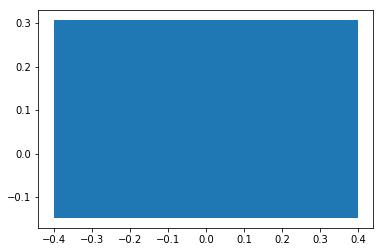

In [75]:
plt.bar(np.arange(len(logreg.coef_)), height=logreg.coef_.ravel())

In [76]:
logreg.score(X_test, y_test)

0.9866542726246598

In [77]:
from sklearn.metrics import classification_report

y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     89158
          1       0.50      0.15      0.23      1208

avg / total       0.98      0.99      0.98     90366



# Conclusion on the logistic regression classifier

The `1` class precision and recall is very low (0) hence this model can't be used for real world scenario. This will serve as a baseline model which we will eventually construct

In [78]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [79]:
xgb.score(X_test, y_test)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.987484230794768

In [80]:
print(classification_report(y_test, xgb.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     89158
          1       0.65      0.14      0.23      1208

avg / total       0.98      0.99      0.98     90366



C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Result after using boosting: We improved the precision from 0% to 56%

# Building regression mode for paying cusomters

In [81]:
paid_features = features[features["totals.transactionRevenue"] > 1]

In [82]:
from sklearn.preprocessing import StandardScaler

y_scal = StandardScaler()
paid_features["totals.transactionRevenue"] = y_scal.fit_transform(paid_features["totals.transactionRevenue"].values.reshape(-1, 1))

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [83]:
# extract paying customers
X_train, X_test, y_train, y_test = train_test_split(paid_features[reqd_columns].drop("totals.transactionRevenue", axis=1), paid_features["totals.transactionRevenue"], test_size=0.1)

In [84]:
from xgboost import XGBRegressor

xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [85]:
y_train

683738   -0.075301
873075    0.324707
263386   -0.241318
773666   -0.242702
605024    0.282880
89939     0.833669
57300    -0.212206
314081    0.717889
581574   -0.235942
131272   -0.227019
249554   -0.253766
883145   -0.255997
434930   -0.264474
126712   -0.036775
468516   -0.014756
46647    -0.119917
410602   -0.237727
655876    0.181199
458427    0.129823
729719   -0.108875
574787   -0.271680
650282   -0.157440
806078   -0.186842
95306    -0.264474
633435   -0.098769
318879   -0.185972
694509   -0.169955
589469   -0.209195
464456    1.165481
647827   -0.244843
            ...   
41064     0.236255
634690   -0.209150
658467   -0.153156
724604   -0.185035
673374   -0.226997
694496   -0.186842
589411    0.500987
816340   -0.268044
594826   -0.237348
362135   -0.273398
622959   -0.173502
89843    -0.173457
477175   -0.149007
589389   -0.255551
296205   -0.260459
239373   -0.063790
655823   -0.235942
406736   -0.184276
183972   -0.189117
581562   -0.168170
883185   -0.078982
60988    -0.

In [86]:
y_pred = xgbr.predict(X_test)
y_pred

array([-0.04095972, -0.17240179,  0.02246591, ..., -0.07331318,
       -0.12925744, -0.26390314], dtype=float32)

In [105]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("MSE on transformed: {}".format(mse))

MSE on transformed: 2.060904626997702


In [87]:
from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [108]:
y_pred = ols.predict(X_test)
print("MSE on transformed: {}".format(mean_squared_error(y_test, y_pred)))

MSE on transformed: 1.6452898247289278


In [88]:
ols.coef_

array([ 1.00551112e-02,  2.53747159e-02,  1.43357548e-14, -7.84878557e-03,
       -9.43147021e-02,  1.20230215e-13,  3.54369312e-14, -5.48973836e-02,
       -5.07912406e-04, -2.40732108e-04, -1.78438576e-06,  5.45051432e-05,
       -3.80576299e-03, -8.15320034e-17,  1.16920478e-02, -9.41749538e-02,
       -9.91179454e-03,  2.93767336e-03,  4.26776508e-03, -4.18171054e-06,
        2.13388254e-03,  1.70710603e-02, -7.87536389e-02, -3.09487889e-02,
       -6.67246963e-02, -2.77555756e-17, -5.21368413e-02, -2.05017080e-05,
       -6.93889390e-18, -1.63171175e-02,  1.97515531e-02,  8.78462808e-04,
       -1.38228814e-02, -1.62651162e-04,  1.11221736e-02, -1.42611260e-04,
        9.68416154e-03, -4.24537837e-03,  1.43787400e-03, -1.15460444e-01])

In [89]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [90]:
y_pred = gbr.predict(X_test)
print("MSE on transformed: {}".format(mean_squared_error(y_test, y_pred)))

MSE on transformed: 0.21041822922110978


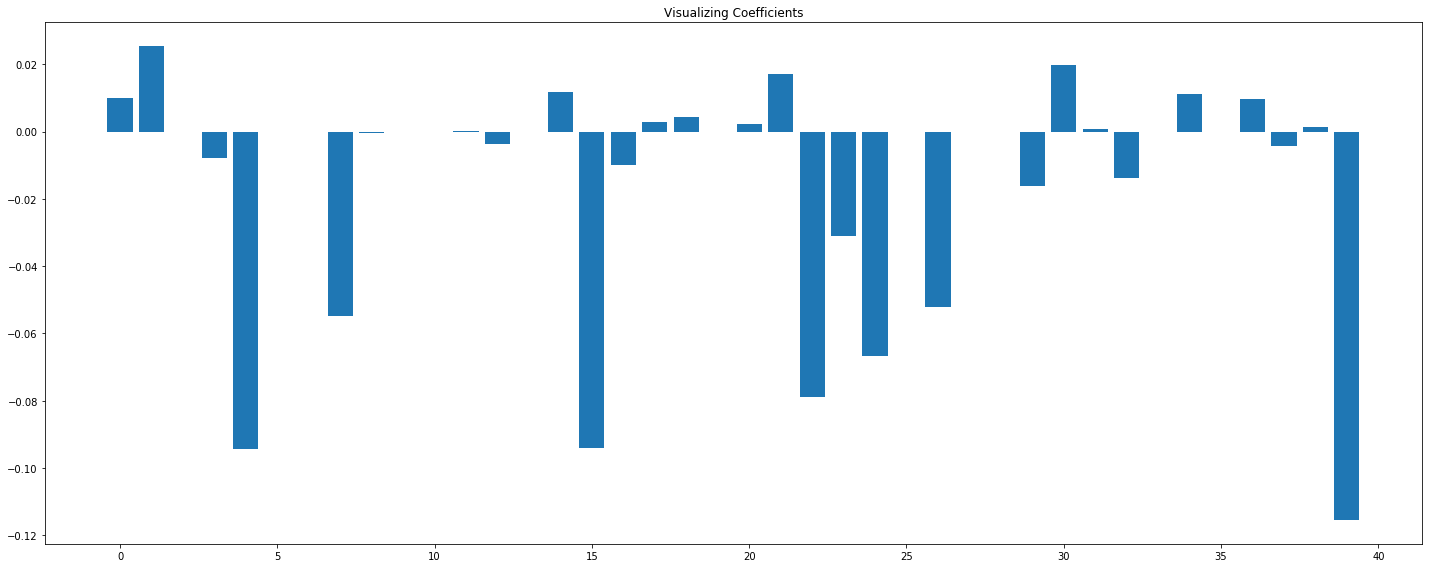

In [91]:
plt.figure(figsize=(20, 8))
plt.bar(np.arange(len(ols.coef_)), height=ols.coef_)
plt.title("Visualizing Coefficients")
plt.tight_layout();

# Comparing Boosting and OLS

In [92]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [93]:
y_pred = gbr.predict(X_test)
print("MSE on transformed (Boosting): {}".format(mean_squared_error(y_test, y_pred)))

MSE on transformed (Boosting): 0.2109691869058209


In [94]:
y_pred = ols.predict(X_test)
print("MSE on transformed(OLS): {}".format(mean_squared_error(y_test, y_pred)))

MSE on transformed(OLS): 0.3064787951627577


In [67]:
# grid searched best params --- very slow cell
params = {'n_estimators': 500, 'max_depth': 7, 'min_samples_split': len(train) // 100, 'min_samples_leaf': 100,
          'learning_rate': 0.1, 'loss': 'ls', 'subsample': 0.8}

cls = GradientBoostingRegressor(**params)
cls.fit(train_X, train_Y)
preds = cls.predict(test_X)

preds[preds<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":test["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = test["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(preds)

val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print('------')
print(np.sqrt(mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
print('------')

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
# to do grid search -- takes hours to run

In [ ]:

# for est in [10, 25, 50, 60, 75, 100, 250, 500][::-1]:
#     for depth in range(4, 8):
#         for min_samples_leaf in [25, 50, 100]:
#             for learn in [.1, .05, .01]:
#                 params = {'n_estimators': est, 'max_depth': depth, 'min_samples_split': len(train) // 100, 'min_samples_leaf': min_samples_leaf,
#                           'learning_rate': learn, 'loss': 'ls', 'subsample': 0.8}
#                 cls = GradientBoostingRegressor(**params)
#                 cls.fit(train_X, train_Y)
#                 preds = cls.predict(test_X)

#                 preds[preds<0] = 0
#                 val_pred_df = pd.DataFrame({"fullVisitorId":test["fullVisitorId"].values})
#                 val_pred_df["transactionRevenue"] = test["totals.transactionRevenue"].values
#                 val_pred_df["PredictedRevenue"] = np.expm1(preds)

#                 val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
#                 print('------')
#                 print(est, depth, min_samples_leaf, learn)
#                 print(np.sqrt(mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
#                 print('------')

In [ ]:
plt.hist(preds, bins=50)

In [ ]:
# plot feature importances

In [ ]:
feature_importance = cls.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(25,10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

plt.show()

In [90]:
# print features w/ scores > 0 to filter to above

In [91]:
for f in list(zip(feature_importance[sorted_idx], train.columns[sorted_idx])):
    if f[0] > 0.00:
        print('"'+f[1]+'",', f[0])


"totals.transactionRevenue", 0.0010869512719693642
"trafficSource.source", 0.0392943902213538
"trafficSource.adwordsClickInfo.adNetworkType", 0.0649294087785223
"month", 0.0778957808771398
"day", 0.08082773064554648
"year", 0.08400059502087748
"fullVisitorId", 0.08895547458101982
"trafficSource.keyword", 0.10389017028561319
"startyear", 0.10706056684013952
"geoNetwork.subContinent", 0.11975982506932624
"startmonth", 0.1303448413146087
"sessionId", 0.16338611536356829
"startday", 0.16514317611448617
"geoNetwork.networkDomain", 0.21008197842416532
"channelGrouping", 0.30765296527960806
"device.deviceCategory", 0.8943397450117319
"geoNetwork.metro", 1.165893777352222
"device.isMobile", 1.3901330853137928
"geoNetwork.region", 1.4091500438844915
"starthour", 1.5010954890978205
"trafficSource.campaign", 1.8657067986116458
"totals.newVisits", 1.890360418258961
"visitId", 6.554869555247156
"visitNumber", 8.881766684057082
"geoNetwork.continent", 9.529470595499228
"totals.hits", 10.013142423597

In [102]:
test_df = json_read('test.csv')

In [103]:
test_df = process_numbers(test_df)
test_df = process_date(test_df)

In [104]:
constant_columns = [col for col in test_df.columns if test_df[col].nunique() == 1]

test_df.drop(constant_columns, axis=1, inplace=True) 

In [105]:
test_df['trafficSource.keyword'] = test_df['trafficSource.keyword'].fillna('Other').apply(clean_keyword)


In [106]:

for col in cat_cols:
    if unique_counts[col] <= 100 or True:
        
        lbl = encoders[col]
        le_dict = dict(zip(lbl.classes_, lbl.transform(lbl.classes_)))

        test_df[col] = [le_dict.get(x, -1) for x in (list(test_df[col].values.astype('str')))]


In [107]:
test_df

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,year,day,month,startweekday,startyear,startday,startmonth,starthour,days_since_first,is_holiday
0,-1,2017-10-16,6167871330617112363,6167871330617112363_1508151024,1508151024,2,2017-10-16 10:50:24,-1,-1,False,...,-1,16,2,0,-1,8,2,2,27.100000,False
1,-1,2017-10-16,0643697640977915618,0643697640977915618_1508175522,1508175522,1,2017-10-16 17:38:42,-1,-1,False,...,-1,16,2,0,-1,8,2,9,44.112500,False
2,-1,2017-10-16,6059383810968229466,6059383810968229466_1508143220,1508143220,1,2017-10-16 08:40:20,-1,-1,False,...,-1,16,2,0,-1,8,2,22,21.680556,False
3,-1,2017-10-16,2376720078563423631,2376720078563423631_1508193530,1508193530,1,2017-10-16 22:38:50,-1,-1,True,...,-1,16,2,0,-1,8,2,15,56.618056,False
4,-1,2017-10-16,2314544520795440038,2314544520795440038_1508217442,1508217442,1,2017-10-17 05:17:22,-1,-1,False,...,-1,16,2,1,-1,9,2,19,13.223611,False
5,-1,2017-10-16,4133039884103392367,4133039884103392367_1508186358,1508186358,1,2017-10-16 20:39:18,-1,-1,False,...,-1,16,2,0,-1,8,2,13,51.637500,False
6,-1,2017-10-16,4320478850207397557,4320478850207397557_1508203650,1508203650,1,2017-10-17 01:27:30,-1,-1,False,...,-1,16,2,1,-1,9,2,1,3.645833,False
7,-1,2017-10-16,5876438247590157131,5876438247590157131_1508184397,1508184397,1,2017-10-16 20:06:37,-1,-1,False,...,-1,16,2,0,-1,8,2,13,50.275694,False
8,-1,2017-10-16,0514591268737702944,0514591268737702944_1508189652,1508189652,6,2017-10-16 21:34:12,-1,-1,False,...,-1,16,2,0,-1,8,2,14,53.925000,False
9,-1,2017-10-16,6430567031531677212,6430567031531677212_1508175502,1508175502,1,2017-10-16 17:38:22,-1,-1,False,...,-1,16,2,0,-1,8,2,9,44.098611,False


In [108]:
# test_df = test_df[good_features]

In [109]:
test_df = test_df.drop(['visitStartTime', 'date'], axis=1)

In [110]:

for column_iter in bagged_categorical_features:
    lbl = encoders[column_iter]
    
    le_dict = dict(zip(lbl.classes_, lbl.transform(lbl.classes_)))
    print(le_dict)
    test_df[column_iter] = [x if le_dict.get(x, -1) > cutoff else 'Other' for x in (list(test_df[column_iter].values.astype('str')))]
    
    
    test_df[column_iter] = lbl.transform(list(test_df[column_iter].values.astype('str')))


{'Other': 0}
{'Other': 0}
{'Other': 0}
{'Other': 0}
{'Other': 0}


In [111]:
preds = cls.predict(test_df)


/Users/ben/Desktop/freelance_kaggle/project/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.
/Users/ben/Desktop/freelance_kaggle/project/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/ben/Desktop/freelance_kaggle/project/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.00000e+00, 3.00000e+00, 1.70000e+01, 3.40000e+01, 1.46000e+02,
        5.50000e+02, 2.76500e+03, 7.46514e+05, 3.47310e+04, 1.86100e+04]),
 array([-8.87996129, -7.70936004, -6.53875879, -5.36815754, -4.1975563 ,
        -3.02695505, -1.8563538 , -0.68575255,  0.4848487 ,  1.65544995,
         2.8260512 ]),
 <a list of 10 Patch objects>)

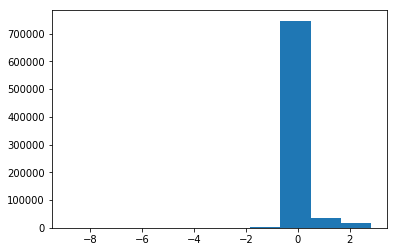

In [112]:
plt.hist(np.log1p(preds))

In [113]:

preds[preds<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

val_pred_df["PredictedLogRevenue"] = np.log1p(preds)

val_pred_df = val_pred_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()

In [114]:
to_write = val_pred_df[['fullVisitorId', 'PredictedLogRevenue']].rename(index=str).fillna(0)

In [115]:
with open('submission.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['fullVisitorId', 'PredictedLogRevenue'])
    for _, row in to_write.iterrows():
        writer.writerow(row)